In [1]:
import glob
import os
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pickle
from dtw import dtw

import sys
sys.path.insert(0, "C:/Users/NCTU/Desktop/WhoTakeWhat/3_Similarity_Scoring/Reaching_and_Taken/Scoring")
sys.path.insert(0, "C:/Users/NCTU/Desktop/WhoTakeWhat/3_Similarity_Scoring/Velocity_Correlation/Scoring")
sys.path.insert(0, "C:/Users/NCTU/Desktop/WhoTakeWhat/3_Similarity_Scoring/Position_Correlation/Scoring")
import Reaching_and_Taken
import Velocity_Correlation
import Position_Correlation

In [2]:
# camera_loc = [-0.83, -0.39, 1.4] #ex1
# camera_loc = [-1.13, -0.33, 1.6] #ex2
# camera_dire_forEarX = -1 #180 degree

#ex3
# camera_loc = [-0.11, -0.32, 1.84] 
# camera_dire_forEarY = -1 #180 degree

#ex4
camera_loc = [-0.05, -0.12, 1.9] 
camera_dire_forEarY = -1 #180 degree

#For demo
##ex2
# camera_loc = [-0.11, -0.21, 2.39]
# camera_dire_forEarY = -1 #180 degree

In [3]:
#Loading config
config_path = 'C:/Users/NCTU/Desktop/WhoTakeWhat/2_Event_Detection/Reach_Out_Detection/config/'
config = pickle.load(open(config_path + 'config.pkl', 'rb'))

#Loading results of Reaching out detection
ro_path = r'C:/Users/NCTU/Desktop/WhoTakeWhat/data/result/Event_Detection'                     # use your path
ro_all_files = glob.glob(os.path.join(ro_path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

ro_namedfs = {}
for file in ro_all_files:
#     print(file)
    name = file.split('\\')[-1].split('.')[0]
#     print(name)
    ro_df = pd.read_csv(file, header=None, names=['yn','timestamp'])
    ro_df['timestamp'] = pd.to_datetime(ro_df['timestamp'], format='%H:%M:%S:%f')
    ro_namedfs[name] = ro_df
    
#Loading results of object detection
obDe_df = pd.read_csv('C:/Users/NCTU/Desktop/WhoTakeWhat/data/result/Event_Detection/objects/objects.csv', 
                      header=None, 
                      names=['yn', 'what', 'frame_number', 'timestamp'])

#Loading list of taken objects
taken_list = pd.read_csv('C:/Users/NCTU/Desktop/WhoTakeWhat/data/result/Event_Detection/objects/taken_list.csv', 
                      header=None)[0].values


#Loading raw inertial data of user
ro_raw_path = r'C:/Users/NCTU/Desktop/WhoTakeWhat/data/IMU/forRO/testing'                     # use your path
ro_raw_all_files = glob.glob(os.path.join(ro_raw_path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

ro_raw_namedfs = {}
for file in ro_raw_all_files:
    name = file.split('\\')[-1].split('.')[0]
    ro_raw_df = pd.read_csv(file, header=None, names=['earx', 'eary', 'earz', 'accx', 'accy', 'accz', 'gyrox', 'gyroy', 'gyroz', 'timestamp'])
    ro_raw_df['timestamp'] = pd.to_datetime(ro_raw_df['timestamp'], format='%H:%M:%S:%f')
    ro_raw_namedfs[name] = ro_raw_df
    
    
#Loading result of Position by Depth camera
position_pd = pd.read_csv('C:/Users/NCTU/Desktop/WhoTakeWhat/data/result/PID/result.csv', header=None)
position_pd.columns = ["timestamp" if x==position_pd.shape[1]-1 else ("a%d" % x) for x in range(position_pd.shape[1])]
position_pd['timestamp'] = pd.to_datetime(position_pd["timestamp"], format='%H:%M:%S:%f')

In [4]:
#Get taken event range
obDe_all_index = obDe_df.index[obDe_df['yn']==1]
obDe_all_index = obDe_all_index.tolist()

obDe_all_split_index = []

obDe_split_index = []
obDe_split_index.append(obDe_all_index.pop(0))

while obDe_all_index:
    nextframe = obDe_all_index.pop(0)
    if nextframe - obDe_split_index[-1] == 1:
        obDe_split_index.append(nextframe)
    else:
        obDe_all_split_index.append(obDe_split_index.copy())
        del obDe_split_index[:]
        obDe_split_index = [nextframe]        
obDe_all_split_index.append(obDe_split_index.copy())

In [5]:
#For Storing detail scoring
result_scoring = dict()

In [6]:
#Algo. Position_Correlation
Position_Correlation_result = Position_Correlation.PositionCorrelation(position_pd, camera_loc, obDe_df, obDe_all_split_index)
result_scoring['Position_Correlation'] = Position_Correlation_result
print('PC result', Position_Correlation_result)

PC result {0: [['Hsin', 'bottle_3', 10.194972641587484], ['Yd', 'bottle_3', 5.868960377638607]], 1: [['Hsin', 'bottle_4', 9.788971189507642], ['Yd', 'bottle_4', 5.692570096502842]], 2: [['Hsin', 'bottle_2', 11.185917884541833], ['Yd', 'bottle_2', 5.751599013682608]], 3: [['Hsin', 'bottle_1', 11.674255704980846], ['Yd', 'bottle_1', 5.417211601491906]], 4: [['Hsin', 'bottle_0', 11.870790851466229], ['Yd', 'bottle_0', 5.728974613868766]]}


C:\Users\NCTU\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


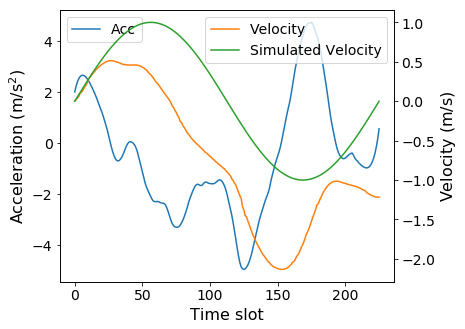

Correlation: [122.42570486]


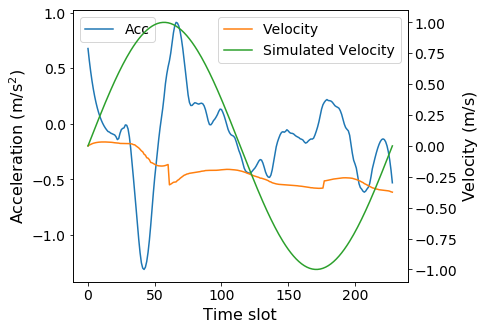

Correlation: [11.88956422]


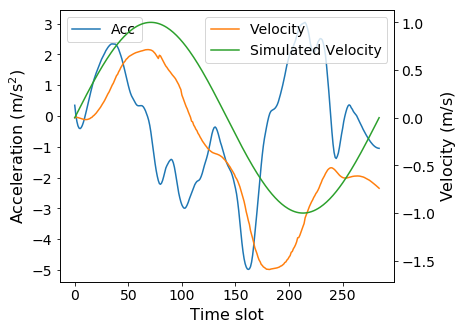

Correlation: [128.75564303]


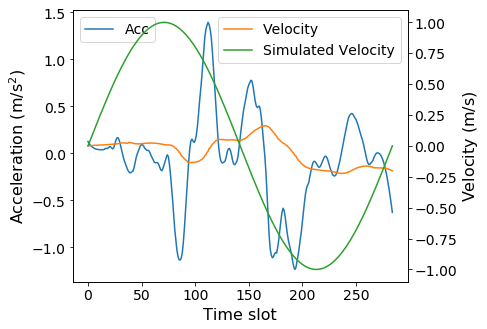

Correlation: [9.05459707]


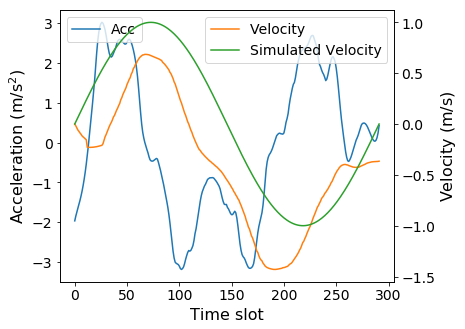

Correlation: [116.0971094]


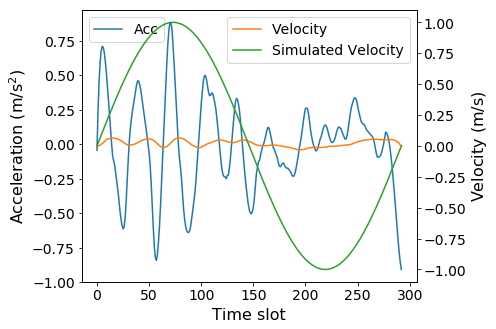

Correlation: [2.23308971]


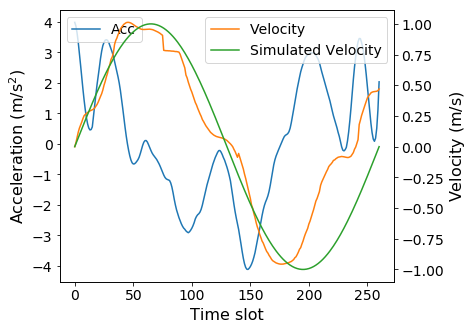

Correlation: [102.72533677]


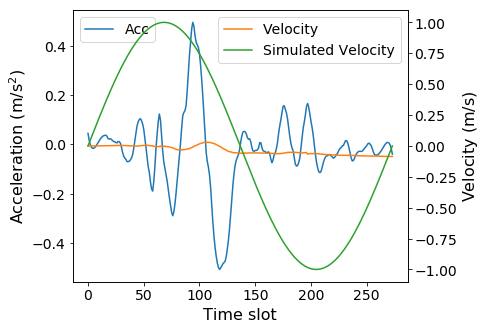

Correlation: [5.41856707]


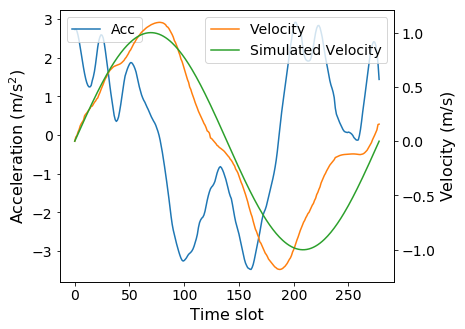

Correlation: [122.76915369]


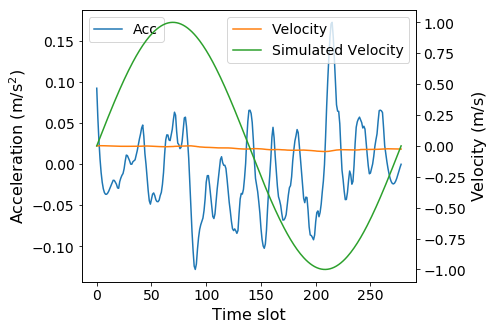

Correlation: [2.4802459]
VC result {0: [['Hsin', 'bottle_3', 122.42570485913683], ['Yd', 'bottle_3', 11.889564219911119]], 1: [['Hsin', 'bottle_4', 128.7556430345387], ['Yd', 'bottle_4', 9.054597067162204]], 2: [['Hsin', 'bottle_2', 116.09710940278397], ['Yd', 'bottle_2', 2.233089711597641]], 3: [['Hsin', 'bottle_1', 102.72533677059478], ['Yd', 'bottle_1', 5.4185670733936]], 4: [['Hsin', 'bottle_0', 122.76915368789682], ['Yd', 'bottle_0', 2.480245896622554]]}


In [7]:
#Algo. Velocity_Correlation
#earX
# Velocity_Correlation_result = Velocity_Correlation.VelocityCorrelation_earx(ro_raw_namedfs, obDe_df, obDe_all_split_index, camera_dire_forEarX)
#earY
Velocity_Correlation_result = Velocity_Correlation.VelocityCorrelation_eary(ro_raw_namedfs, obDe_df, obDe_all_split_index, camera_dire_forEarY)
result_scoring['Velocity_Correlation'] = Velocity_Correlation_result
print('VC result', Velocity_Correlation_result)

In [8]:
1/0

ZeroDivisionError: division by zero

In [ ]:
#Algo. Reaching_and_Taken
Reaching_and_Taken_result = Reaching_and_Taken.ReachingAndTaken(ro_namedfs, obDe_df, obDe_all_split_index)
result_scoring['Reaching_and_Taken'] = Reaching_and_Taken_result
print('RT result', Reaching_and_Taken_result)

In [ ]:
#Algo. Ensemble
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

Ensemble_results = {}
for times, taken_event_range in enumerate(obDe_all_split_index):
    PC_name = []
    object_ = ''
    PC_scores = []
    for PC in Position_Correlation_result[times]:
        PC_name.append(PC[0])
        object_ = PC[1]
        PC_scores.append(PC[2])
    PC_scores_norm = scaler.fit_transform(np.array(PC_scores).reshape(-1,1)).T[0].tolist()
    
    VC_name = []
    VC_scores = []
    for VC in Velocity_Correlation_result[times]:
        VC_name.append(VC[0])
        VC_scores.append(VC[2])
    VC_scores_norm = scaler.fit_transform(np.array(VC_scores).reshape(-1,1)).T[0].tolist()   
    
    RT_name = []
    RT_scores = []
    for RT in Reaching_and_Taken_result[times]:
        RT_name.append(RT[0])
        RT_scores.append(RT[2])
    RT_scores_norm = scaler.fit_transform(np.array(RT_scores).reshape(-1,1)).T[0].tolist()

    #initial
    sim_en = {}
    for name in PC_name:
        sim_en[name] = 0
    
    for name, s in zip(PC_name, PC_scores_norm):
        temp_list = PC_scores_norm.copy()
        temp_list.remove(s)
        _mu = np.mean(temp_list)
#         print('PC',s, _mu)
        sim_en[name] = sim_en[name] + (s-_mu)
    for name, s in zip(VC_name, VC_scores_norm):
        temp_list = VC_scores_norm.copy()
        temp_list.remove(s)
        _mu = np.mean(temp_list)
#         print('VC',s, _mu)
        sim_en[name] = sim_en[name] + (s-_mu)
    for name, s in zip(RT_name, RT_scores_norm):
        temp_list = RT_scores_norm.copy()
        temp_list.remove(s)
        _mu = np.mean(temp_list)
#         print('RT',s, _mu)
        sim_en[name] = sim_en[name] + (s-_mu) 
    
    Ensemble_result = []
    for name, score in sim_en.items():
        Ensemble_result.append([name, object_, score])
    Ensemble_results[times] = Ensemble_result

result_scoring['Ensemble'] = Ensemble_results
print('Ensemble result', Ensemble_results)

In [ ]:
#HighestDifference
HD_results = {}
for times, taken_event_range in enumerate(obDe_all_split_index):
    PC_name = []
    object_ = ''
    PC_scores = []
    for PC in Position_Correlation_result[times]:
        PC_name.append(PC[0])
        object_ = PC[1]
        PC_scores.append(PC[2])
    PC_scores_norm = scaler.fit_transform(np.array(PC_scores).reshape(-1,1)).T[0].tolist()
    PC_scores_norm, PC_name = zip(*sorted(zip(PC_scores_norm, PC_name), reverse=True))
    
    VC_name = []
    VC_scores = []
    for VC in Velocity_Correlation_result[times]:
        VC_name.append(VC[0])
        VC_scores.append(VC[2])
    VC_scores_norm = scaler.fit_transform(np.array(VC_scores).reshape(-1,1)).T[0].tolist()   
    VC_scores_norm, VC_name = zip(*sorted(zip(VC_scores_norm, VC_name), reverse=True))
    
    RT_name = []
    RT_scores = []
    for RT in Reaching_and_Taken_result[times]:
        RT_name.append(RT[0])
        RT_scores.append(RT[2])
    RT_scores_norm = scaler.fit_transform(np.array(RT_scores).reshape(-1,1)).T[0].tolist()
    RT_scores_norm, RT_name = zip(*sorted(zip(RT_scores_norm, RT_name), reverse=True))
    
    #initial
    sim_hd = {}
    for name in PC_name:
        sim_hd[name] = 0
    
    temp_name = []
    temp_score = []
    
    temp_name.append(PC_name[0])
    temp_score.append(PC_scores_norm[0] - PC_scores_norm[1])
    temp_name.append(VC_name[0])
    temp_score.append(VC_scores_norm[0] - VC_scores_norm[1])
    temp_name.append(RT_name[0])
    temp_score.append(RT_scores_norm[0] - RT_scores_norm[1])
    temp_score, temp_name = zip(*sorted(zip(temp_score, temp_name), reverse=True))
    
    sim_hd[temp_name[0]] = 1
    #for voting
    voting_otherwise = []
    voting_otherwise.append(temp_name[0])
    
    HD_result = []
    for name, score in sim_hd.items():
        HD_result.append([name, object_, score])
    HD_results[times] = HD_result

result_scoring['HD'] = HD_results
print('HD result', HD_results)

In [ ]:
#Voting
Vote_results = {}
for times, taken_event_range in enumerate(obDe_all_split_index):
    PC_name = []
    object_ = ''
    PC_scores = []
    for PC in Position_Correlation_result[times]:
        PC_name.append(PC[0])
        object_ = PC[1]
        PC_scores.append(PC[2])
    PC_scores_norm = scaler.fit_transform(np.array(PC_scores).reshape(-1,1)).T[0].tolist()
    PC_scores_norm, PC_name = zip(*sorted(zip(PC_scores_norm, PC_name), reverse=True))
    
    VC_name = []
    VC_scores = []
    for VC in Velocity_Correlation_result[times]:
        VC_name.append(VC[0])
        VC_scores.append(VC[2])
    VC_scores_norm = scaler.fit_transform(np.array(VC_scores).reshape(-1,1)).T[0].tolist()   
    VC_scores_norm, VC_name = zip(*sorted(zip(VC_scores_norm, VC_name), reverse=True))
    
    RT_name = []
    RT_scores = []
    for RT in Reaching_and_Taken_result[times]:
        RT_name.append(RT[0])
        RT_scores.append(RT[2])
    RT_scores_norm = scaler.fit_transform(np.array(RT_scores).reshape(-1,1)).T[0].tolist()
    RT_scores_norm, RT_name = zip(*sorted(zip(RT_scores_norm, RT_name), reverse=True))
    
    #initial
    sim_vote = {}
    temp_dict = {}
    for name in PC_name:
        sim_vote[name] = 0
        temp_dict[name] = 0
    
    temp_dict[PC_name[0]] = temp_dict[PC_name[0]] + 1
    temp_dict[VC_name[0]] = temp_dict[VC_name[0]] + 1
    temp_dict[RT_name[0]] = temp_dict[RT_name[0]] + 1
    
    temp_dict_sorted = sorted(temp_dict.items(), key=lambda kv: kv[1], reverse=True)
    if (temp_dict_sorted[0][1] - temp_dict_sorted[1][1])!=0:
        sim_vote[temp_dict_sorted[0][0]] = 1
    else:
        sim_vote[voting_otherwise[times]] = 1
    
    vote_result = []
    for name, score in sim_vote.items():
        vote_result.append([name, object_, score])
    Vote_results[times] = vote_result

result_scoring['Voting'] = Vote_results
print('Voting result', Vote_results)

In [ ]:
#Matching Algo.
pair_dict = {}
for SSname, Correlation_results in zip(['PC','VC','RT','EN', 'HD', 'Voting'], [Position_Correlation_result, Velocity_Correlation_result, Reaching_and_Taken_result, Ensemble_results, HD_results, Vote_results]):
    reli = []
    for times, taken_event_range in enumerate(obDe_all_split_index):
        B = nx.Graph()
        #Add person node
        B.add_nodes_from(ro_namedfs.keys(), bipartite=0)
        #Add object node
        B.add_nodes_from(np.unique(np.array(Reaching_and_Taken_result[times])[:, 1]), bipartite=1)
        #Add edge
        per_obj_wei = {}
        
        scores = []
        for nos in Correlation_results[times]:
            scores.append(nos[2])
        scores_norm = scaler.fit_transform(np.array(scores).reshape(-1,1)).T[0].tolist()    
        
        for result_1, score in zip(Correlation_results[times], scores_norm):
            per_obj_wei[(result_1[0], result_1[1])] = score

#         for result_2 in Velocity_Correlation_result[times]:
#             per_obj_wei[(result_2[0], result_2[1])] = per_obj_wei[(result_2[0], result_2[1])] + result_2[2]

#         for result_3 in Position_Correlation_result[times]:
#             per_obj_wei[(result_3[0], result_3[1])] = per_obj_wei[(result_3[0], result_3[1])] + result_3[2]
#     #     print(per_obj_wei)

        for per_obj, wei in per_obj_wei.items():
            B.add_edges_from([(per_obj[0], per_obj[1])], weight=wei)
#         bottom_nodes, top_nodes = bipartite.sets(B)
#         print(bottom_nodes, top_nodes)
        pair = nx.max_weight_matching(B).pop()
        reli.append(pair)
        
        
    pair_dict[SSname] = reli
        
print(pair_dict)
#     print(bipartite.maximum_matching(B))

##    Drawing
#     pos = dict()
#     pos.update( (n, (1, i)) for i, n in enumerate(bottom_nodes) ) # put nodes from X at x=1
#     pos.update( (n, (2, i)) for i, n in enumerate(top_nodes) ) # put nodes from Y at x=2
#     print(pos)
#     nx.draw(B, pos=pos)
#     1/0

In [ ]:
#Visualization.
vis = []
for times, taken_event in enumerate(obDe_all_split_index):
    VC_result = []
    what_list = []
    whatsets = obDe_df.loc[taken_event[0]:taken_event[-1], ['what']].values
    for whatset in whatsets:
        whats = whatset[0].split(',')
        for what in whats:
            if what not in what_list:
                what_list.append(what)
    for what in what_list:
        what_detected_times_df = obDe_df.loc[obDe_df['what'].str.contains(what), ['timestamp']].reset_index(drop=True)
        what_detected_times_df['timestamp'] = pd.to_datetime(what_detected_times_df['timestamp'], format='%H:%M:%S:%f')
        ob_start_time = what_detected_times_df.iloc[0]['timestamp']
        ob_end_time = what_detected_times_df.iloc[what_detected_times_df.shape[0]-1]['timestamp']
        
        delta = (ob_end_time - ob_start_time).total_seconds()
        delta = datetime.timedelta(seconds=delta)
#         windows_quarter_delta = datetime.timedelta(seconds=config['windows_size']/2)
        ro_start_time = ob_start_time - delta
        ro_end_time = ob_end_time + delta
        
        text_result = ''
        whotakewhat = pair_dict['HD']
        for whoorwhat in whotakewhat[times]:
            if whoorwhat not in taken_list:
                 who = whoorwhat

        text_result = text_result + ': ' +  who
        print(what,text_result)
        vis.append([what+text_result, ro_end_time])

pd.DataFrame(np.array(vis)).to_csv('C:/Users/NCTU/Desktop/WhoTakeWhat/data/result/Matching/match_res.csv', header=None, index=None)


pd.DataFrame(result_scoring).to_csv('C:/Users/NCTU/Desktop/WhoTakeWhat/data/result/Matching/score_detail.csv', index=None)